# <center><span style='background:yellow'> Détectez les Bad Buzz grâce au Deep Learning</span></center>
# <center><span style='background:yellow'>Modèle de Deep Learning avec une couche embedding et une couche LSTM</span></center> 
===================================================================================================================

## Sommaire <a class="anchor" id="sommaire"></a>

* [Import des librairies, chargement des données](#00)
* [1. Nettoyage avec lemmatisation et vectorisation avec Word2Vec](#10)  
* [2. Nettoyage avec lemmatisation et vectorisation avec Glove](#20)  
* [3. Nettoyage avec Stemming et vectorisation avec Word2Vec](#30)  
* [4. Nettoyage avec Stemming et vectorisation avec Glove](#40)  

## Import des librairies, chargement des données<a class="anchor" id="00"></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%pip install gensim==4.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 133.3 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [3]:
import numpy as np
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import gensim
from gensim.models import KeyedVectors
import keras
import gensim.downloader
import tensorflow
from tensorflow.keras import models
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import models, Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout, LSTM
from tensorflow.keras.layers import Bidirectional, GlobalAveragePooling1D

# Version des librairie
print('Tensorflow version :', tensorflow.__version__)
print('Keras version :', keras.__version__)
print('gensim version :', gensim.__version__)

Tensorflow version : 2.9.2
Keras version : 2.9.0
gensim version : 4.2.0


In [4]:
# Chargement des données
path = '/content/drive/MyDrive/p7/'

In [5]:
train = pd.read_csv(path + 'data/train.csv', index_col=0, encoding='utf-8')
validation = pd.read_csv(path + 'data/validation.csv', index_col=0, encoding='utf-8')

train.dropna(inplace=True)
validation.dropna(inplace=True)

In [6]:
train.head()

,tweet,label,tweet_clean_lemm,tweet_clean_stem
1273151,#Goodsex When he makes you squirt all over him,1,goodsex make squirt,goodsex make squirt
445145,Looking for a &quot;Sexy Sailors&quot; outfit ...,0,look quot;sexy sailors&quot outfit laura hen n...,look quot;sexi sailors&quot outfit laura hen n...
499993,i dont know why twitter just now sent that thr...,0,not know twitter send word headache,nt know twitter sent word headach
122529,A particularly brutal rejection has put me off...,0,particularly brutal rejection writing never co...,particular brutal reject write never consid eg...
1322335,@bets_carabuena dear! sa friday pa dito thurs...,1,dear sa friday pa dito thursday ang game,dear sa friday pa dito thursday ang game


In [7]:
ytrain, yval = train.label, validation.label

In [8]:
train_lem = train.tweet_clean_lemm
train_stem = train.tweet_clean_stem

val_lem = validation.tweet_clean_lemm
val_stem = validation.tweet_clean_stem

In [9]:
# initialisation des paramètres
seed = 0
batch_size = 500
epochs = 200

<a href="##sommaire" rev="footnote">&#8617;</a>

In [10]:
w2v_vectors_lemm = KeyedVectors.load(path + "embedding/lemm_word2vec.wordvectors")
w2v_vectors_stem = KeyedVectors.load(path + "embedding/stem_word2vec.wordvectors")

## Nettoyage avec lemmatisation et vectorisation avec Word2Vec<a class="anchor" id="10"></a>

**Test le tokenizer de Keras**

In [11]:
import pickle

tk_lemm = Tokenizer()
tk_lemm.fit_on_texts(train.tweet_clean_lemm.to_list())

# saving
with open(path + 'models/tk_lemm.pickle', 'wb') as handle:
    pickle.dump(tk_lemm, handle)

In [12]:
tk_lemm.document_count

625617

In [13]:
len(tk_lemm.word_counts)

154397

In [14]:
list(tk_lemm.word_counts.items())[:10]

[('goodsex', 57),
 ('make', 7137),
 ('squirt', 14),
 ('look', 15632),
 ('quot', 28563),
 ('sexy', 727),
 ('sailors', 2),
 ('outfit', 209),
 ('laura', 175),
 ('hen', 39)]

In [15]:
list(tk_lemm.word_index.items())[:10]

[('not', 1),
 ('go', 2),
 ('good', 3),
 ('day', 4),
 ('work', 5),
 ('get', 6),
 ('like', 7),
 ('love', 8),
 ('quot', 9),
 ('today', 10)]

In [16]:
SeqText = tk_lemm.texts_to_sequences(train.tweet_clean_lemm.to_list())

In [17]:
SeqText[:4]

[[5472, 75, 13056],
 [26, 9, 761, 40321, 9, 2144, 2446, 7010, 21, 899, 410, 1, 7],
 [1, 14, 31, 162, 274, 264],
 [4426, 4796, 8408, 1418, 76, 937, 3539, 7011, 533]]

In [18]:
train.tweet_clean_lemm.iloc[:4,]

1273151                                  goodsex make squirt
445145     look quot;sexy sailors&quot outfit laura hen n...
499993                   not know twitter send word headache
122529     particularly brutal rejection writing never co...
Name: tweet_clean_lemm, dtype: object

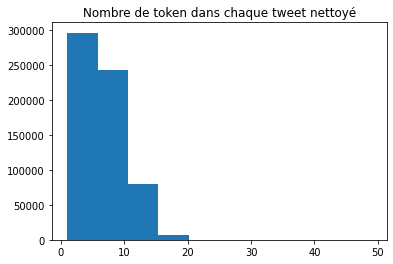

In [19]:
plt.hist([len(doc) for doc in SeqText])
plt.title('Nombre de token dans chaque tweet nettoyé')
plt.show()

In [20]:
max_len = max([len(doc) for doc in SeqText])

In [21]:
# Création de la matrice d'embedding
def build_embedding_matrix(serie, model_vectors, size = 200):
    list_docs = serie.to_list()
    print("Fit Tokenizer ...")
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(list_docs)
    print("Create Embedding matrix ...")
    word_index = tokenizer.word_index
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, size))
    i=0
    j=0
    miss = []
    for word, idx in word_index.items():
        i +=1
        if word in model_vectors.key_to_index:
            j +=1
            embedding_vector = model_vectors[word]
            
            if embedding_vector is not None:
                embedding_matrix[idx] = model_vectors[word]
                
            else :
                miss.append(word)
            
    word_rate = np.round(j/i,4)
    print("Word embedding rate : ", word_rate)
    print("Embedding matrix shape: " , embedding_matrix.shape)
    
    return {'Embedding_matrix' : embedding_matrix, 'Words_not_found' : miss}

In [22]:
size = 200
embedding_matrix_lem_w2v = build_embedding_matrix(train.tweet_clean_lemm, 
                                                  model_vectors = w2v_vectors_lemm, 
                                                  size = size)['Embedding_matrix']

Fit Tokenizer ...
Create Embedding matrix ...
Word embedding rate :  0.8915
Embedding matrix shape:  (154398, 200)


In [23]:
# Définition de la fonction de Préparation des sentences (tokenization)
def prepare_data(serie, maxlen = 205, tokenizer=tk_lemm, pprint = None):
    if pprint:
        print(pprint)
    list_docs = serie.to_list()
    tokenizer.texts_to_sequences(list_docs)
    input_data = pad_sequences(tokenizer.texts_to_sequences(list_docs),
                                maxlen = maxlen,
                                padding = 'post')
    print('Len vocab :', len(tokenizer.word_counts))
    print('Len tweets :', input_data.shape[0])
    print('Done! \n')
    return input_data

In [24]:
xtrain_lem = prepare_data(train.tweet_clean_lemm, 
                          pprint='Preparing the train set : ')

xval_lem = prepare_data(validation.tweet_clean_lemm, 
                        pprint='Preparing the validation set : ')

Preparing the train set : 
Len vocab : 154397
Len tweets : 625617
Done! 

Preparing the validation set : 
Len vocab : 154397
Len tweets : 268092
Done! 



In [25]:
xtrain_lem.shape, xval_lem.shape

((625617, 205), (268092, 205))

In [26]:
embedding_matrix_lem_w2v.shape

(154398, 200)

### Baseline

In [27]:
def lstm_embedding(embedding_matrix,
                   len_vocab = 154398,
                   output_dim = 200,
                   max_len = 200,
                   len_padding = 5,
                   seed=0):

  tensorflow.random.set_seed(seed)

  model = Sequential()

  model.add(Embedding(input_dim = len_vocab ,
                             output_dim = output_dim,
                             embeddings_initializer = keras.initializers.Constant(embedding_matrix),
                             input_length = max_len + len_padding,
                             trainable = False))
  model.add(Bidirectional(LSTM(10)))
  model.add(Flatten())
  model.add(Dense(1, activation="sigmoid"))
  model.compile(optimizer = 'adam', 
                       loss = 'binary_crossentropy', 
                       metrics = ['acc'])
  return model

In [28]:
embedding_matrix = embedding_matrix_lem_w2v
lstm_lemm_w2v = lstm_embedding(embedding_matrix = embedding_matrix,
                                 seed = 0)

lstm_lemm_w2v.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 205, 200)          30879600  
                                                                 
 bidirectional (Bidirectiona  (None, 20)               16880     
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 20)                0         
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 30,896,501
Trainable params: 16,901
Non-trainable params: 30,879,600
_________________________________________________________________


In [29]:
%%time
history_lemm_w2v = lstm_lemm_w2v.fit(xtrain_lem, 
                             ytrain,
                             validation_data = (xval_lem, yval),
                             epochs = epochs,
                             batch_size = batch_size,
                             verbose = 1)

Epoch 1/200
1252/1252 [==============================] - 41s 25ms/step - loss: 0.5068 - acc: 0.7522 - val_loss: 0.4837 - val_acc: 0.7671
Epoch 2/200
1252/1252 [==============================] - 31s 25ms/step - loss: 0.4786 - acc: 0.7701 - val_loss: 0.4754 - val_acc: 0.7712
Epoch 3/200
1252/1252 [==============================] - 31s 25ms/step - loss: 0.4710 - acc: 0.7745 - val_loss: 0.4711 - val_acc: 0.7746
Epoch 4/200
1252/1252 [==============================] - 31s 25ms/step - loss: 0.4668 - acc: 0.7768 - val_loss: 0.4695 - val_acc: 0.7753
Epoch 5/200
1252/1252 [==============================] - 31s 25ms/step - loss: 0.4641 - acc: 0.7788 - val_loss: 0.4682 - val_acc: 0.7763
Epoch 6/200
1252/1252 [==============================] - 32s 25ms/step - loss: 0.4620 - acc: 0.7803 - val_loss: 0.4679 - val_acc: 0.7762
Epoch 7/200
1252/1252 [==============================] - 32s 25ms/step - loss: 0.4604 - acc: 0.7812 - val_loss: 0.4673 - val_acc: 0.7770
Epoch 8/200
1252/1252 [==================

In [30]:
def plot_history(history, list_key) :
    # summarize history for accuracy
    plt.plot(history.history[list_key[0]])
    plt.plot(history.history[list_key[2]])
    plt.title(f'model {list_key[0]}')
    plt.ylabel(list_key[0])
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history[list_key[1]])
    plt.plot(history.history[list_key[3]])
    plt.title(f'model {list_key[1]}')
    plt.ylabel(list_key[1])
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

#### Learning Curve

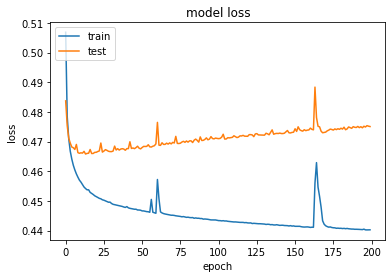

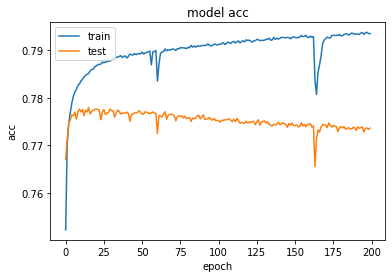

In [31]:
history = history_lemm_w2v
plot_history(history, list(history.history.keys()))

#### Evaluation du modèle

In [32]:
evaluate = lstm_lemm_w2v.evaluate(xval_lem, yval, verbose=0)

print('Loss score %.2f : \nAccuracy score: %.2f'%(evaluate[0], evaluate[1]))

Loss score 0.48 : 
Accuracy score: 0.77


### Amélioration du modèle

In [33]:
len_vocab = 154_398
output_dim = 200
max_len = 200
len_padding = 5

tensorflow.random.set_seed(seed)

lstm_lemm_w2v_optimised = Sequential()

lstm_lemm_w2v_optimised.add(Embedding(input_dim = len_vocab,
                            output_dim = output_dim,
                            embeddings_initializer = keras.initializers.Constant(embedding_matrix),
                            input_length = max_len + len_padding,
                            trainable = False))

lstm_lemm_w2v_optimised.add(Bidirectional(LSTM(10))) 

lstm_lemm_w2v_optimised.add(Dropout(0.5))

lstm_lemm_w2v_optimised.add(Flatten())

lstm_lemm_w2v_optimised.add(Dense(10, activation='relu'))

lstm_lemm_w2v_optimised.add(Dropout(0.5))

lstm_lemm_w2v_optimised.add(Dense(1, activation="sigmoid"))

lstm_lemm_w2v_optimised.compile(optimizer = 'adam', 
                       loss = 'binary_crossentropy', 
                       metrics = ['acc'])


In [34]:
lstm_lemm_w2v_optimised.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 205, 200)          30879600  
                                                                 
 bidirectional_1 (Bidirectio  (None, 20)               16880     
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 flatten_1 (Flatten)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                      

In [35]:
from time import time

learning_times = {}
t0 = time()

history_lemm_w2v_optimised = lstm_lemm_w2v_optimised.fit(xtrain_lem, 
                             ytrain,
                             validation_data = (xval_lem, yval),
                             epochs = epochs,
                             batch_size = batch_size,
                             verbose = 1)

learning_times['lemm_word2vec'] = time() - t0

Epoch 1/200
1252/1252 [==============================] - 35s 26ms/step - loss: 0.5796 - acc: 0.7053 - val_loss: 0.5009 - val_acc: 0.7600
Epoch 2/200
1252/1252 [==============================] - 32s 25ms/step - loss: 0.5353 - acc: 0.7470 - val_loss: 0.4879 - val_acc: 0.7662
Epoch 3/200
1252/1252 [==============================] - 31s 25ms/step - loss: 0.5262 - acc: 0.7528 - val_loss: 0.4826 - val_acc: 0.7695
Epoch 4/200
1252/1252 [==============================] - 31s 25ms/step - loss: 0.5223 - acc: 0.7546 - val_loss: 0.4817 - val_acc: 0.7708
Epoch 5/200
1252/1252 [==============================] - 31s 25ms/step - loss: 0.5194 - acc: 0.7570 - val_loss: 0.4803 - val_acc: 0.7703
Epoch 6/200
1252/1252 [==============================] - 32s 25ms/step - loss: 0.5178 - acc: 0.7573 - val_loss: 0.4774 - val_acc: 0.7722
Epoch 7/200
1252/1252 [==============================] - 32s 25ms/step - loss: 0.5165 - acc: 0.7584 - val_loss: 0.4749 - val_acc: 0.7730
Epoch 8/200
1252/1252 [==================

#### Learning Curve

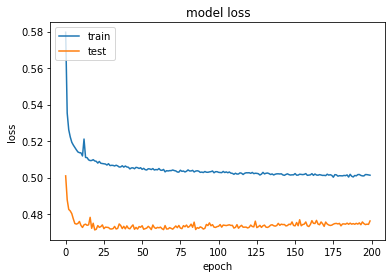

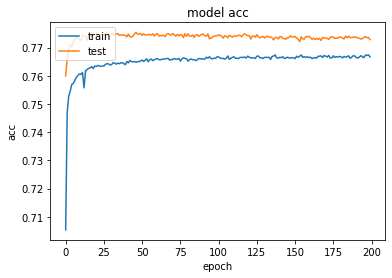

In [36]:
history = history_lemm_w2v_optimised

plot_history(history, list(history.history.keys()))

#### Evaluation du modèle

In [37]:
evaluate = lstm_lemm_w2v_optimised.evaluate(xval_lem, yval, verbose=0)

print('Loss score %.2f : \nAccuracy score: %.2f'%(evaluate[0], evaluate[1]))

Loss score 0.48 : 
Accuracy score: 0.77


#### Sauvegarde du modèle

In [38]:
# saving model architecture and weights
 
# save model architecture
lstm_lemm_w2v_optimised.save(path + 'models/lstm_lemm_w2v.h5')
 
# save model weights
lstm_lemm_w2v_optimised.save_weights(path + 'models/lstm_lemm_w2v_weights')
print('Model Saved!')

Model Saved!


<a href="##sommaire" rev="footnote">&#8617;</a>

## Nettoyage avec lemmatisation et vectorisation avec Glove<a class="anchor" id="20"></a>

In [39]:
glove_vectors = KeyedVectors.load(path + "embedding/glove.wordvectors")

In [40]:
embedding_matrix_lemm_glove = build_embedding_matrix(train_lem, glove_vectors)['Embedding_matrix']

Fit Tokenizer ...
Create Embedding matrix ...
Word embedding rate :  0.5262
Embedding matrix shape:  (154398, 200)


### Baseline

In [41]:
embedding_matrix = embedding_matrix_lemm_glove
lstm_lemm_glove = lstm_embedding(embedding_matrix = embedding_matrix, 
                                len_vocab = 154398)
lstm_lemm_glove.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 205, 200)          30879600  
                                                                 
 bidirectional_2 (Bidirectio  (None, 20)               16880     
 nal)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 20)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 30,896,501
Trainable params: 16,901
Non-trainable params: 30,879,600
_________________________________________________________________


In [42]:
%%time
history_lemm_glove = lstm_lemm_glove.fit(xtrain_lem, 
                             ytrain,
                             validation_data = (xval_lem, yval),
                             epochs = epochs,
                             batch_size = batch_size,
                             verbose = 1)

Epoch 1/200
1252/1252 [==============================] - 35s 26ms/step - loss: 0.5074 - acc: 0.7500 - val_loss: 0.4843 - val_acc: 0.7649
Epoch 2/200
1252/1252 [==============================] - 31s 25ms/step - loss: 0.4770 - acc: 0.7703 - val_loss: 0.4732 - val_acc: 0.7728
Epoch 3/200
1252/1252 [==============================] - 31s 25ms/step - loss: 0.4697 - acc: 0.7751 - val_loss: 0.4685 - val_acc: 0.7754
Epoch 4/200
1252/1252 [==============================] - 31s 25ms/step - loss: 0.4655 - acc: 0.7778 - val_loss: 0.4663 - val_acc: 0.7774
Epoch 5/200
1252/1252 [==============================] - 31s 25ms/step - loss: 0.4626 - acc: 0.7794 - val_loss: 0.4651 - val_acc: 0.7778
Epoch 6/200
1252/1252 [==============================] - 31s 25ms/step - loss: 0.4605 - acc: 0.7809 - val_loss: 0.4634 - val_acc: 0.7786
Epoch 7/200
1252/1252 [==============================] - 31s 25ms/step - loss: 0.4588 - acc: 0.7817 - val_loss: 0.4631 - val_acc: 0.7794
Epoch 8/200
1252/1252 [==================

#### Learning Curve

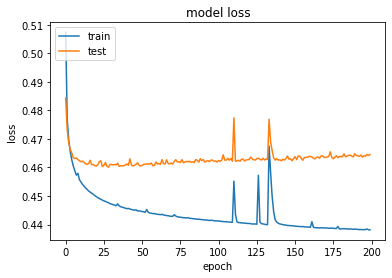

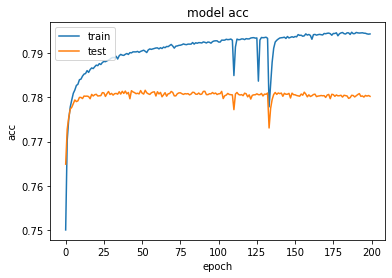

In [43]:
history = history_lemm_glove
plot_history(history, list(history.history.keys()))

#### Evaluation du modèle

In [44]:
evaluate = lstm_lemm_glove.evaluate(xval_lem, yval, verbose=0)

print('Loss score %.2f : \nAccuracy score: %.2f '%(evaluate[0], evaluate[1]))

Loss score 0.46 : 
Accuracy score: 0.78 


### Amélioration du modèle

In [45]:
len_vocab = 154398
output_dim = 200
max_len = 200
len_padding = 5

tensorflow.random.set_seed(seed)

lstm_lemm_glove_optimised = Sequential()

lstm_lemm_glove_optimised.add(Embedding(input_dim = len_vocab ,
                             output_dim = output_dim,
                             embeddings_initializer = keras.initializers.Constant(embedding_matrix),
                             input_length = max_len + len_padding,
                             trainable = False))

lstm_lemm_glove_optimised.add(Bidirectional(LSTM(10)))
lstm_lemm_glove_optimised.add(Dropout(0.7))
lstm_lemm_glove_optimised.add(Flatten())

lstm_lemm_w2v_optimised.add(Dense(10, activation='relu'))
lstm_lemm_w2v_optimised.add(Dropout(0.7))

lstm_lemm_w2v_optimised.add(Dense(5, activation='relu'))
lstm_lemm_w2v_optimised.add(Dropout(0.7))

lstm_lemm_glove_optimised.add(Dense(1, activation="sigmoid"))
lstm_lemm_glove_optimised.compile(optimizer = 'adam', 
                       loss = 'binary_crossentropy', 
                       metrics = ['acc'])

In [46]:
lstm_lemm_glove_optimised.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 205, 200)          30879600  
                                                                 
 bidirectional_3 (Bidirectio  (None, 20)               16880     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 20)                0         
                                                                 
 flatten_3 (Flatten)         (None, 20)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 21        
                                                                 
Total params: 30,896,501
Trainable params: 16,901
Non-trainable params: 30,879,600
_____________________________________

In [47]:
t0 = time()
history_lemm_glove_optimised = lstm_lemm_glove_optimised.fit(xtrain_lem, 
                             ytrain,
                             validation_data = (xval_lem, yval),
                             epochs = epochs,
                             batch_size = batch_size,
                             verbose = 1)
learning_times['lemm_glove'] = time() - t0

Epoch 1/200
1252/1252 [==============================] - 35s 25ms/step - loss: 0.5527 - acc: 0.7275 - val_loss: 0.4990 - val_acc: 0.7593
Epoch 2/200
1252/1252 [==============================] - 32s 25ms/step - loss: 0.5271 - acc: 0.7464 - val_loss: 0.4891 - val_acc: 0.7644
Epoch 3/200
1252/1252 [==============================] - 31s 25ms/step - loss: 0.5200 - acc: 0.7498 - val_loss: 0.4849 - val_acc: 0.7678
Epoch 4/200
1252/1252 [==============================] - 31s 25ms/step - loss: 0.5168 - acc: 0.7520 - val_loss: 0.4812 - val_acc: 0.7692
Epoch 5/200
1252/1252 [==============================] - 31s 25ms/step - loss: 0.5138 - acc: 0.7542 - val_loss: 0.4786 - val_acc: 0.7709
Epoch 6/200
1252/1252 [==============================] - 31s 25ms/step - loss: 0.5126 - acc: 0.7550 - val_loss: 0.4779 - val_acc: 0.7712
Epoch 7/200
1252/1252 [==============================] - 31s 25ms/step - loss: 0.5106 - acc: 0.7557 - val_loss: 0.4759 - val_acc: 0.7717
Epoch 8/200
1252/1252 [==================

#### Learning Curve

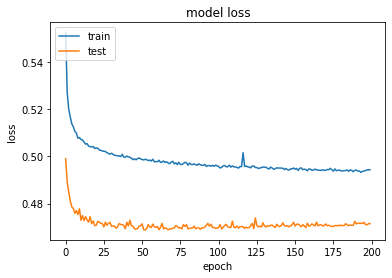

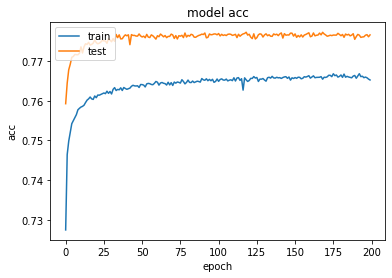

In [48]:
history = history_lemm_glove_optimised
plot_history(history, list(history.history.keys()))

#### Evaluation du modèle

In [49]:
evaluate = lstm_lemm_glove_optimised.evaluate(xval_lem, yval, verbose=0)

print('Loss score %.2f : \nAccuracy score: %.2f'%(evaluate[0], evaluate[1]))

Loss score 0.47 : 
Accuracy score: 0.78


#### Sauvegarde du modèle

In [50]:
# saving model architecture and weights
 
# save model architecture
lstm_lemm_glove_optimised.save(path + 'models/lstm_lemm_glove.h5')
 
# save model weights
lstm_lemm_glove_optimised.save_weights(path + 'models/lstm_lemm_glove_weights')
print('Model Saved!')

Model Saved!


<a href="##sommaire" rev="footnote">&#8617;</a>

## Nettoyage avec stemming et vectorisation avec Word2Vec <a class="anchor" id="30"></a>

In [51]:
size = 200
embedding_matrix_stem_w2v = build_embedding_matrix(train_stem, 
                                                  model_vectors = w2v_vectors_stem, 
                                                  size = size)['Embedding_matrix']

Fit Tokenizer ...
Create Embedding matrix ...
Word embedding rate :  0.8831
Embedding matrix shape:  (138808, 200)


In [52]:
tk_stem = Tokenizer()
tk_stem.fit_on_texts(train_stem)
xtrain_stem = prepare_data(train.tweet_clean_stem, 
                           tokenizer = tk_stem,
                           pprint='Préparing the train set : ')

xval_stem = prepare_data(val_stem, 
                         tokenizer = tk_stem,
                         pprint='Préparing the validation set : ')

Préparing the train set : 
Len vocab : 138807
Len tweets : 625617
Done! 

Préparing the validation set : 
Len vocab : 138807
Len tweets : 268092
Done! 



### Baseline

In [53]:
%%time
embedding_matrix = embedding_matrix_stem_w2v
model_stem_w2v = lstm_embedding(embedding_matrix=embedding_matrix, 
                                len_vocab = 138807+1)

model_stem_w2v.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 205, 200)          27761600  
                                                                 
 bidirectional_4 (Bidirectio  (None, 20)               16880     
 nal)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 20)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 21        
                                                                 
Total params: 27,778,501
Trainable params: 16,901
Non-trainable params: 27,761,600
_________________________________________________________________
CPU times: user 637 ms, sys: 16.5 ms, total: 653 ms
Wall time: 645 ms


In [54]:
history_stem_w2v = model_stem_w2v.fit(xtrain_stem, 
                             ytrain,
                             validation_data = (xval_stem, yval),
                             epochs = epochs,
                             batch_size = batch_size,
                             verbose = 1)                  

Epoch 1/200
1252/1252 [==============================] - 36s 26ms/step - loss: 0.5062 - acc: 0.7532 - val_loss: 0.4807 - val_acc: 0.7702
Epoch 2/200
1252/1252 [==============================] - 32s 26ms/step - loss: 0.4756 - acc: 0.7726 - val_loss: 0.4727 - val_acc: 0.7747
Epoch 3/200
1252/1252 [==============================] - 33s 26ms/step - loss: 0.4682 - acc: 0.7770 - val_loss: 0.4691 - val_acc: 0.7769
Epoch 4/200
1252/1252 [==============================] - 32s 26ms/step - loss: 0.4642 - acc: 0.7792 - val_loss: 0.4674 - val_acc: 0.7769
Epoch 5/200
1252/1252 [==============================] - 32s 26ms/step - loss: 0.4616 - acc: 0.7808 - val_loss: 0.4668 - val_acc: 0.7780
Epoch 6/200
1252/1252 [==============================] - 32s 26ms/step - loss: 0.4597 - acc: 0.7824 - val_loss: 0.4660 - val_acc: 0.7779
Epoch 7/200
1252/1252 [==============================] - 33s 26ms/step - loss: 0.4581 - acc: 0.7829 - val_loss: 0.4660 - val_acc: 0.7783
Epoch 8/200
1252/1252 [==================

#### Learning Curve

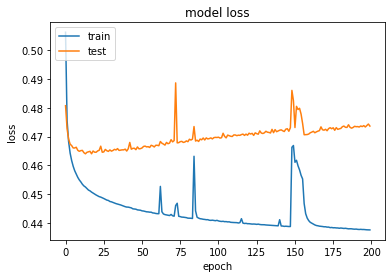

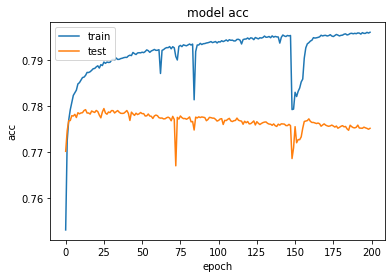

In [55]:
history = history_stem_w2v
plot_history(history, list(history.history.keys()))

#### Evaluation du modèle

In [56]:
evaluate = model_stem_w2v.evaluate(xval_stem, yval, verbose=0)

print('Loss score %.2f : \nAccuracy score: %.2f '%(evaluate[0], evaluate[1]))

Loss score 0.47 : 
Accuracy score: 0.78 


### Amélioration du modèle

In [57]:
embedding_matrix = embedding_matrix_stem_w2v
len_vocab = 138807+1
output_dim = 200
max_len = 200
len_padding = 5

tensorflow.random.set_seed(seed)

lstm_stem_w2v_optimised = Sequential()

lstm_stem_w2v_optimised.add(Embedding(input_dim = len_vocab ,
                             output_dim = output_dim,
                             embeddings_initializer = keras.initializers.Constant(embedding_matrix),
                             input_length = max_len + len_padding,
                             trainable = False))

lstm_stem_w2v_optimised.add(Bidirectional(LSTM(10)))
lstm_stem_w2v_optimised.add(Dropout(0.5))
lstm_stem_w2v_optimised.add(Flatten())
lstm_stem_w2v_optimised.add(Dense(10, activation="relu"))
lstm_stem_w2v_optimised.add(Dropout(0.4))
lstm_stem_w2v_optimised.add(Dense(1, activation="sigmoid"))
lstm_stem_w2v_optimised.compile(optimizer = 'adam', 
                       loss = 'binary_crossentropy', 
                       metrics = ['acc'])



In [58]:
lstm_stem_w2v_optimised.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 205, 200)          27761600  
                                                                 
 bidirectional_5 (Bidirectio  (None, 20)               16880     
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 20)                0         
                                                                 
 flatten_5 (Flatten)         (None, 20)                0         
                                                                 
 dense_8 (Dense)             (None, 10)                210       
                                                                 
 dropout_6 (Dropout)         (None, 10)                0         
                                                      

In [59]:
t0 = time()
history_stem_w2v_optimised = lstm_stem_w2v_optimised.fit(xtrain_stem, 
                             ytrain,
                             validation_data = (xval_stem, yval),
                             epochs = epochs,
                             batch_size = batch_size,
                             verbose = 1)
learning_times['stem_word2vec'] = time() - t0

Epoch 1/200
1252/1252 [==============================] - 37s 27ms/step - loss: 0.5586 - acc: 0.7246 - val_loss: 0.4920 - val_acc: 0.7667
Epoch 2/200
1252/1252 [==============================] - 33s 26ms/step - loss: 0.5214 - acc: 0.7564 - val_loss: 0.4823 - val_acc: 0.7715
Epoch 3/200
1252/1252 [==============================] - 32s 25ms/step - loss: 0.5145 - acc: 0.7603 - val_loss: 0.4781 - val_acc: 0.7728
Epoch 4/200
1252/1252 [==============================] - 32s 25ms/step - loss: 0.5106 - acc: 0.7627 - val_loss: 0.4767 - val_acc: 0.7732
Epoch 5/200
1252/1252 [==============================] - 32s 25ms/step - loss: 0.5083 - acc: 0.7638 - val_loss: 0.4743 - val_acc: 0.7755
Epoch 6/200
1252/1252 [==============================] - 32s 25ms/step - loss: 0.5064 - acc: 0.7644 - val_loss: 0.4726 - val_acc: 0.7762
Epoch 7/200
1252/1252 [==============================] - 32s 25ms/step - loss: 0.5052 - acc: 0.7657 - val_loss: 0.4704 - val_acc: 0.7767
Epoch 8/200
1252/1252 [==================

#### Learning Curve

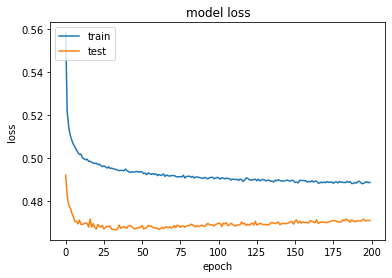

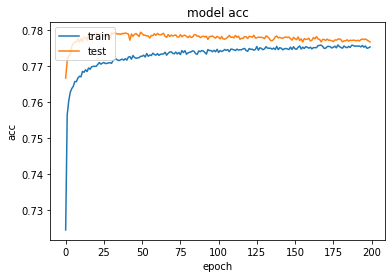

In [60]:
history = history_stem_w2v_optimised
plot_history(history, list(history.history.keys()))

#### Evaluation du modèle

In [61]:
evaluate = lstm_stem_w2v_optimised.evaluate(xval_stem, yval, verbose=0)

print('Loss score %.2f : \nAccuracy score: %.2f'%(evaluate[0], evaluate[1]))

Loss score 0.47 : 
Accuracy score: 0.78


#### Sauvegarde du modèle

In [62]:
# saving model architecture and weights
 
# save model architecture
lstm_stem_w2v_optimised.save(path + 'models/lstm_stem_w2v.h5')
 
# save model weights
lstm_stem_w2v_optimised.save_weights(path + 'models/lstm_stem_w2v_weights')
print('Model Saved!')

Model Saved!


<a href="##sommaire" rev="footnote">&#8617;</a>

## Nettoyage avec stemming et vectorisation avec Glove<a class="anchor" id="4"> </a>

In [63]:
embedding_matrix_stem_glove = build_embedding_matrix(train_stem, glove_vectors)['Embedding_matrix']

Fit Tokenizer ...
Create Embedding matrix ...
Word embedding rate :  0.448
Embedding matrix shape:  (138808, 200)


### Baseline

In [64]:
embedding_matrix = embedding_matrix_stem_glove
lstm_stem_glove = lstm_embedding(embedding_matrix=embedding_matrix, 
                                  len_vocab=138808)
lstm_stem_glove.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 205, 200)          27761600  
                                                                 
 bidirectional_6 (Bidirectio  (None, 20)               16880     
 nal)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 20)                0         
                                                                 
 dense_10 (Dense)            (None, 1)                 21        
                                                                 
Total params: 27,778,501
Trainable params: 16,901
Non-trainable params: 27,761,600
_________________________________________________________________


In [65]:
%%time
history_stem_glove = lstm_stem_glove.fit(xtrain_stem, 
                             ytrain,
                             validation_data = (xval_stem, yval),
                             epochs = epochs,
                             batch_size = batch_size,
                             verbose = 1)

Epoch 1/200
1252/1252 [==============================] - 36s 26ms/step - loss: 0.5183 - acc: 0.7423 - val_loss: 0.4941 - val_acc: 0.7587
Epoch 2/200
1252/1252 [==============================] - 31s 25ms/step - loss: 0.4858 - acc: 0.7645 - val_loss: 0.4816 - val_acc: 0.7672
Epoch 3/200
1252/1252 [==============================] - 31s 25ms/step - loss: 0.4776 - acc: 0.7700 - val_loss: 0.4769 - val_acc: 0.7708
Epoch 4/200
1252/1252 [==============================] - 31s 25ms/step - loss: 0.4730 - acc: 0.7731 - val_loss: 0.4743 - val_acc: 0.7724
Epoch 5/200
1252/1252 [==============================] - 31s 25ms/step - loss: 0.4699 - acc: 0.7753 - val_loss: 0.4725 - val_acc: 0.7739
Epoch 6/200
1252/1252 [==============================] - 31s 25ms/step - loss: 0.4675 - acc: 0.7766 - val_loss: 0.4714 - val_acc: 0.7741
Epoch 7/200
1252/1252 [==============================] - 31s 25ms/step - loss: 0.4657 - acc: 0.7778 - val_loss: 0.4709 - val_acc: 0.7747
Epoch 8/200
1252/1252 [==================

#### Learning Curve

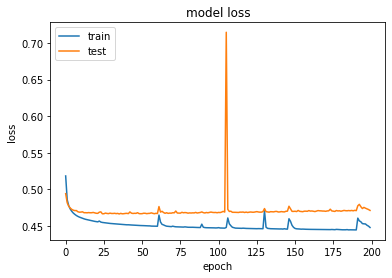

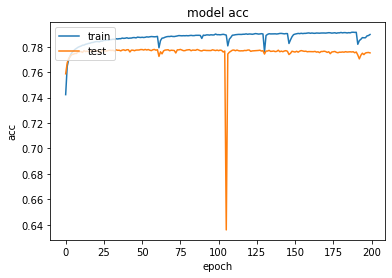

In [66]:
history = history_stem_glove
plot_history(history, list(history.history.keys()))

#### Evaluation du modèle

In [67]:
evaluate = lstm_stem_glove.evaluate(xval_stem, yval, verbose=0)

print('Loss score %.2f : \nAccuracy score: %.2f '%(evaluate[0], evaluate[1]))

Loss score 0.47 : 
Accuracy score: 0.78 


### Amélioration du modèle

In [68]:
embedding_matrix = embedding_matrix_stem_glove
len_vocab = 138808
output_dim = 200
max_len = 200
len_padding = 5

tensorflow.random.set_seed(seed)

lstm_stem_glove_optimised = Sequential()

lstm_stem_glove_optimised.add(Embedding(input_dim = len_vocab ,
                             output_dim = output_dim,
                             embeddings_initializer = keras.initializers.Constant(embedding_matrix),
                             input_length = max_len + len_padding,
                            trainable = False))

lstm_stem_glove_optimised.add(Bidirectional(LSTM(10)))
lstm_stem_glove_optimised.add(Dropout(0.4))
lstm_stem_glove_optimised.add(Flatten())
lstm_stem_glove_optimised.add(Dense(10, activation='relu'))
lstm_stem_glove_optimised.add(Dropout(0.4))
lstm_stem_glove_optimised.add(Dense(1, activation="sigmoid"))
lstm_stem_glove_optimised.compile(optimizer = 'adam', 
                       loss = 'binary_crossentropy', 
                       metrics = ['acc'])

In [69]:
lstm_stem_glove_optimised.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 205, 200)          27761600  
                                                                 
 bidirectional_7 (Bidirectio  (None, 20)               16880     
 nal)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 20)                0         
                                                                 
 flatten_7 (Flatten)         (None, 20)                0         
                                                                 
 dense_11 (Dense)            (None, 10)                210       
                                                                 
 dropout_8 (Dropout)         (None, 10)                0         
                                                      

In [70]:
t0 = time()

history_stem_glove_optimised = lstm_stem_glove_optimised.fit(xtrain_stem, 
                             ytrain,
                             validation_data = (xval_stem, yval),
                             epochs = epochs,
                             batch_size = batch_size,
                             verbose = 1)

learning_times['stem_glove'] = time() - t0

Epoch 1/200
1252/1252 [==============================] - 36s 26ms/step - loss: 0.5547 - acc: 0.7243 - val_loss: 0.4999 - val_acc: 0.7574
Epoch 2/200
1252/1252 [==============================] - 32s 25ms/step - loss: 0.5215 - acc: 0.7518 - val_loss: 0.4905 - val_acc: 0.7620
Epoch 3/200
1252/1252 [==============================] - 32s 25ms/step - loss: 0.5150 - acc: 0.7558 - val_loss: 0.4847 - val_acc: 0.7651
Epoch 4/200
1252/1252 [==============================] - 32s 26ms/step - loss: 0.5112 - acc: 0.7588 - val_loss: 0.4830 - val_acc: 0.7670
Epoch 5/200
1252/1252 [==============================] - 32s 26ms/step - loss: 0.5092 - acc: 0.7609 - val_loss: 0.4807 - val_acc: 0.7687
Epoch 6/200
1252/1252 [==============================] - 32s 25ms/step - loss: 0.5069 - acc: 0.7619 - val_loss: 0.4798 - val_acc: 0.7701
Epoch 7/200
1252/1252 [==============================] - 32s 25ms/step - loss: 0.5058 - acc: 0.7629 - val_loss: 0.4771 - val_acc: 0.7711
Epoch 8/200
1252/1252 [==================

#### Learning Curve

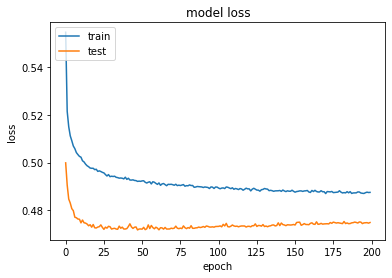

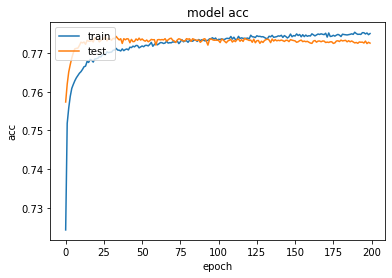

In [71]:
history = history_stem_glove_optimised
plot_history(history, list(history.history.keys()))

#### Evaluation du modèle

In [72]:
evaluate = lstm_stem_glove_optimised.evaluate(xval_stem, yval, verbose=0)

print('Loss score %.2f : \nAccuracy score: %.2f'%(evaluate[0], evaluate[1]))

Loss score 0.47 : 
Accuracy score: 0.77


#### Sauvegarde du modèle

In [73]:
# saving model architecture and weights
 
# save model architecture
lstm_stem_glove_optimised.save(path + 'models/lstm_stem_glove.h5')
 
# save model weights
lstm_stem_glove_optimised.save_weights(path + 'models/lstm_stem_glove_weights')
print('Model Saved!')

Model Saved!


In [74]:
# sauvegarde temsp d'entraînement
import pickle

with open(path + "models/lstm_learning_times.pkl", "wb") as tf:
    pickle.dump(learning_times,tf)
print('Done!')

Done!


<a href="##sommaire" rev="footnote">&#8617;</a>